# Experiment Management with MLFlow Handler

This tutorial shows how to use mlflow handler to management MONAI experiments. Currently it only supports monai engine based training process. In the simplest case, experiment management can be implemented in 2 line by adding mlflow handler to handler list like code shown below.

```
# add mlflow handler to handler list
train_handlers = [...,MLFlowHandler(output_transform=monai.handlers.from_engine(["loss"], first=True))] 
trainer = SupervisedTrainer(..., train_handlers=train_handlers, ...)
```

The other way to add a mlflow handler is using **attach** method defined in handler.

```
mlflow_handler = MLFlowHandler(output_transform=monai.handlers.from_engine(["loss"], first=True))
trainer = SupervisedTrainer(...)

# attach mlflow_handler to monai engine
mlflow_handler.attach(trainer)
```

Adding mlflow in this way, it will create an experiment named "default_experiment" and a run named by current time. A new run will be added to the experiment every time staring a training. With this simplest way, mlflow will record some basic infomation like type of network, loss and optimizer, learning rate, max_epoch and so on. Users can access to these information by running below command in the same directory of mlflow log. Default value of port and host parameter are `127.0.0.1` and `5000`.
```
mlflow ui --port xx --host x.x.x.x
```

After that, users can go to `https://127.0.0.1:5000` and get basic information predefined by mlflow_handler, if using default parameters. The output is shown below.
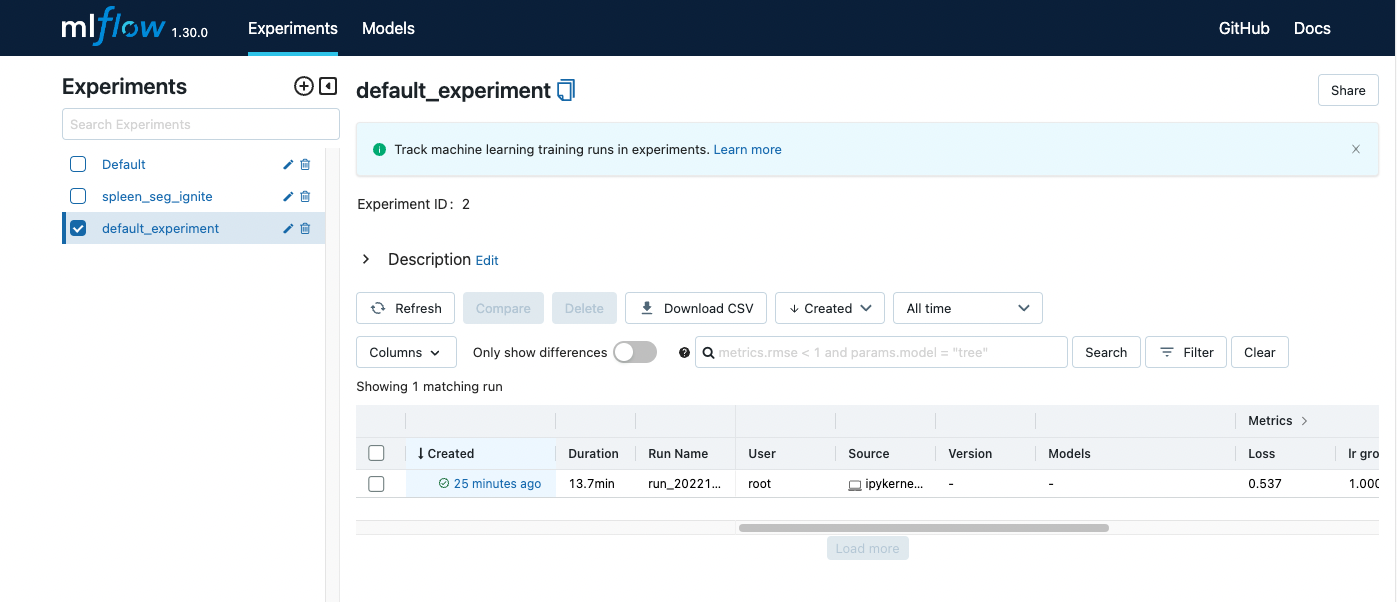

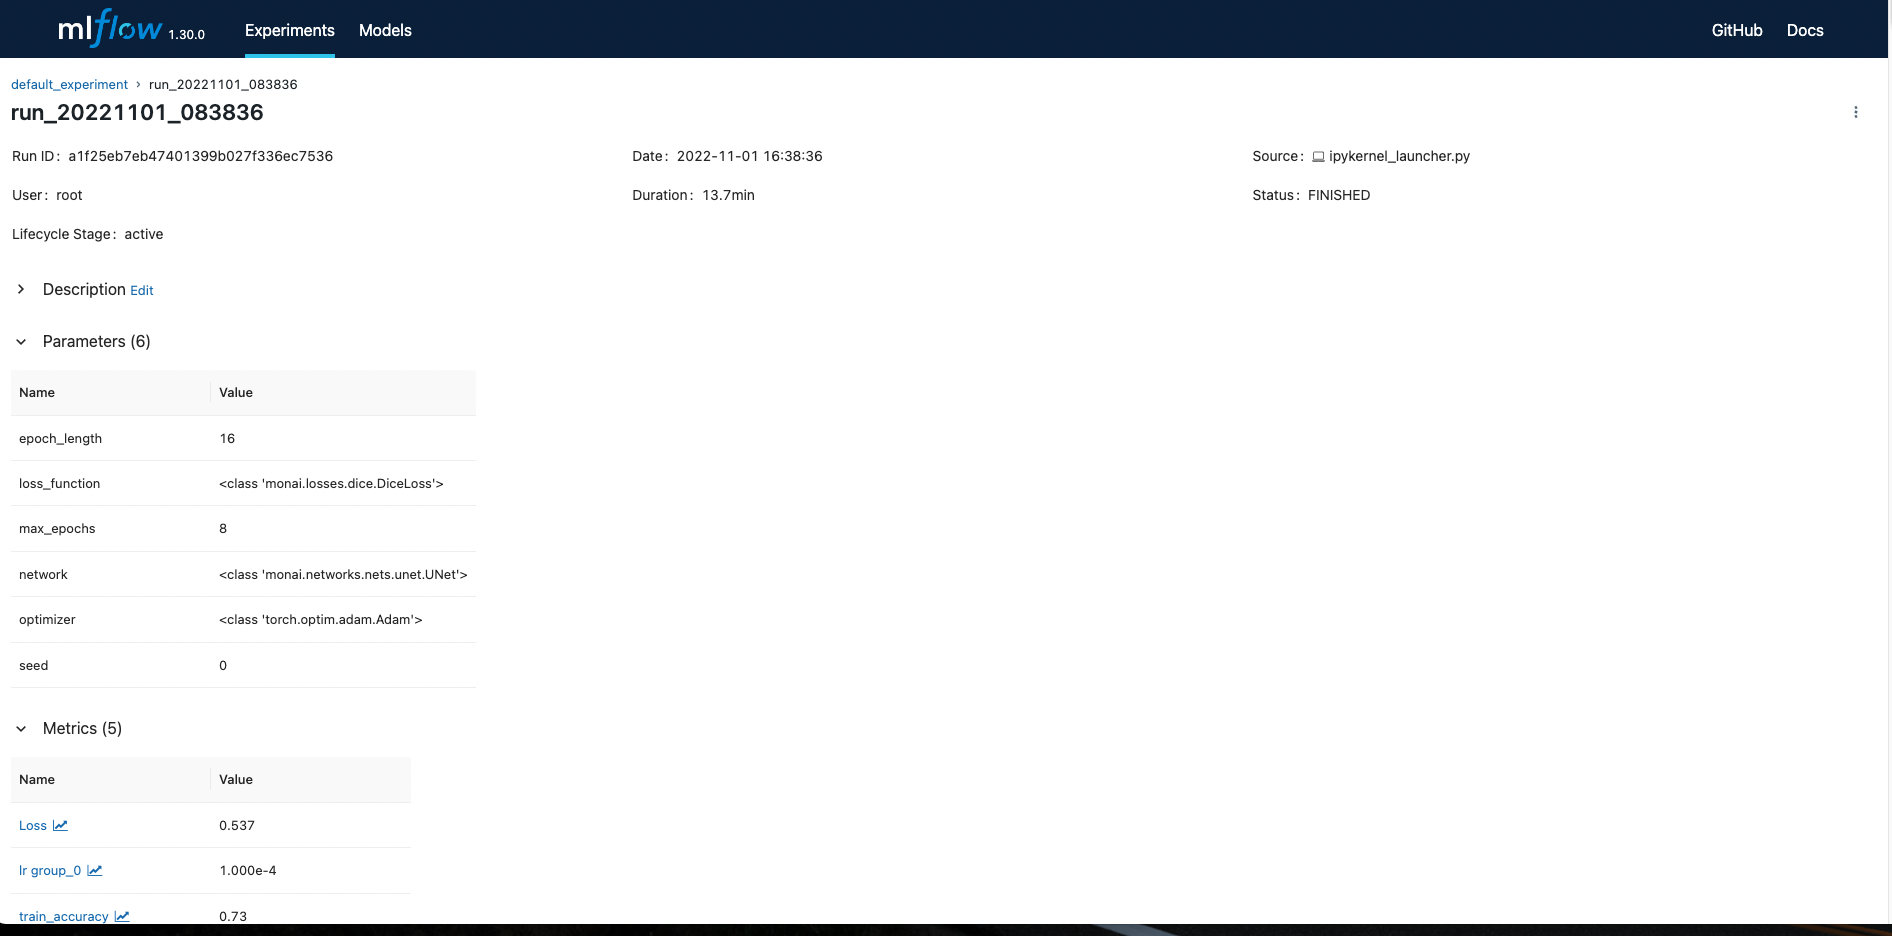
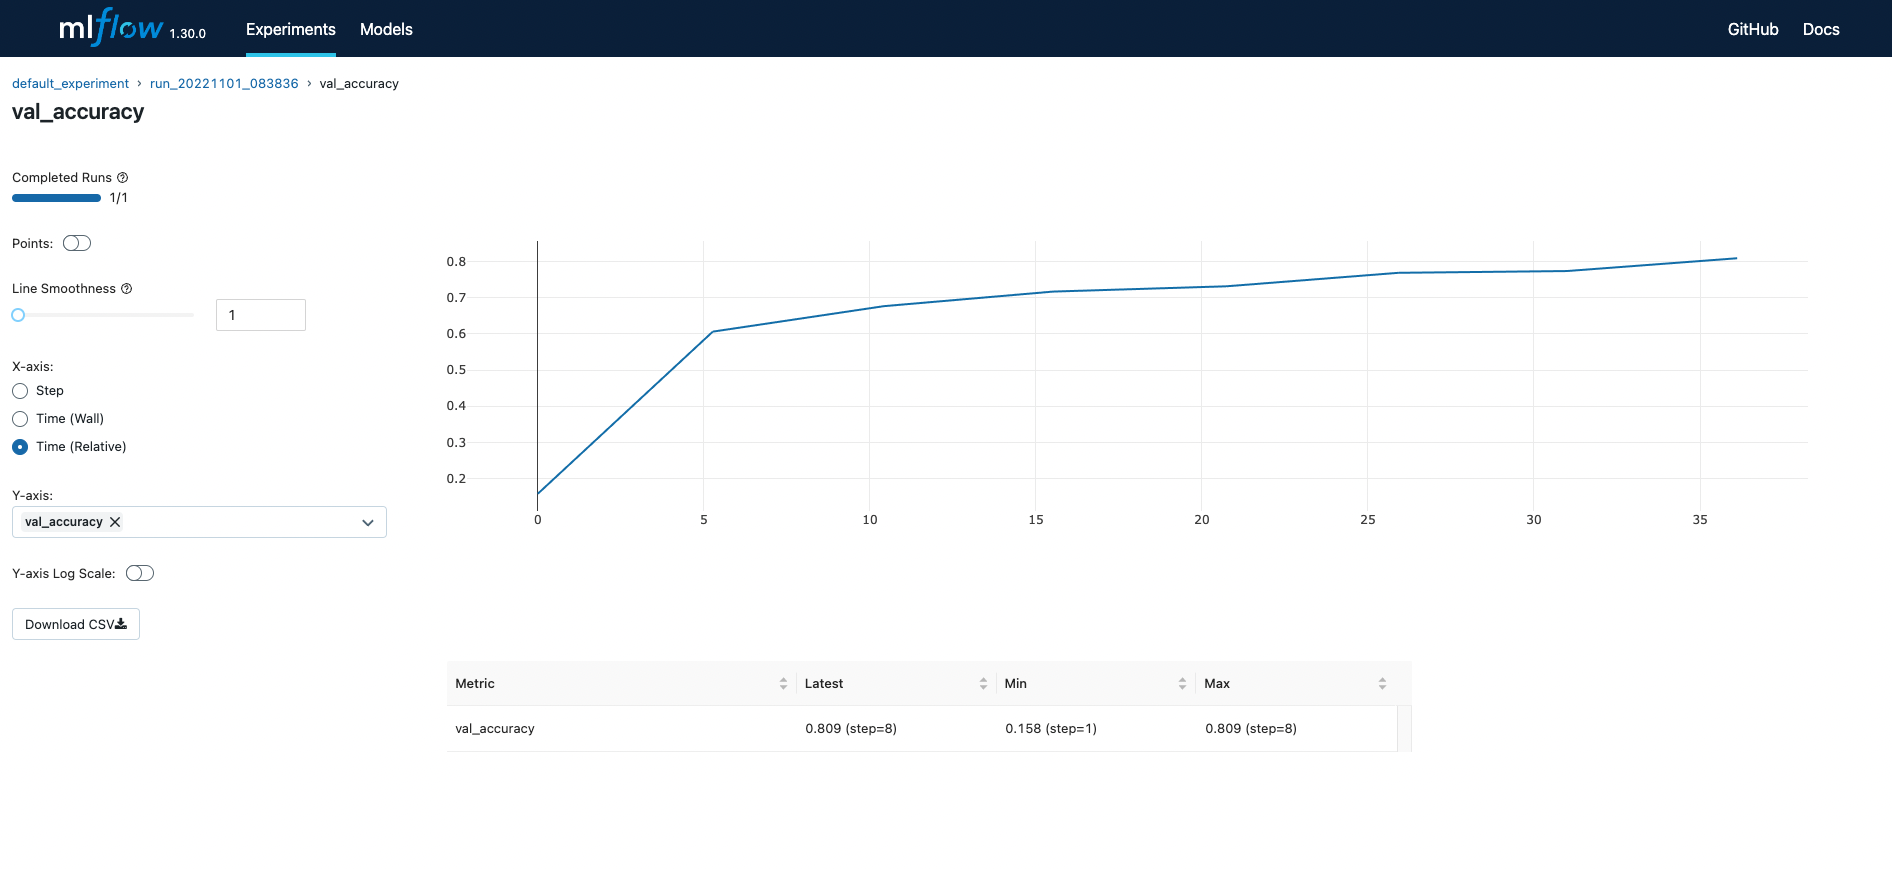

The users can also customize their own experiment management information through methods shown below.

1. The experiment name and run name can also be specified through `experiment_name` and `run_name` parameters in mlflow handler init function.
2. Extra parameters can be added through `experiment_param` parameter in mlflow handler during initialization. Please notice that these parameter should be formated to dict like the unet parameter dict shown below.
```
UNet_metadata = {'spatial_dims': 3,
                 'in_channels': 1,
                 'out_channels': 2,
                 'channels': (16, 32, 64, 128, 256),
                 'strides': (2, 2, 2, 2),
                 'num_res_units': 2,
                 'norm': Norm.BATCH}
```
3. Artifacts like models and images can also be recorded. In order to log these file, the path of them needs to be add to `artifacts` parameter in mlflow_handler. An example of artifacts is shown below.
```
log_artifacts=['/workspace/data/medical/artifact/image1.png', 
               '/workspace/data/medical/artifact/image2.png',...,
               '/workspace/data/medical/artifact/model.pt']
```

[Spleen segmentation mlflow tutorial](https://github.com/Project-MONAI/tutorials/blob/main/experiment_management/spleen_segmentation_mlflow.ipynb) is used here to show the detail of using mlflow hander to do the experiment management. We refactor the pytorch training process to monai engine training process, delete all the mlflow log code and add the mlflow handler in that tutorial to get this one.

## Setup environment

`MLFlow` comes as part of the `monai[all]` installation. For official documentation on MLFlow's experiment management functionalities, click [here](https://www.mlflow.org/docs/latest/tracking.html).

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"

## Setup imports

In [2]:
from monai.utils import set_determinism
from monai.transforms import (
    AsDiscreted,
    Activationsd,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import SlidingWindowInferer, SimpleInferer
from monai.data import CacheDataset, DataLoader, decollate_batch
from monai.config import print_config
from monai.engines import SupervisedTrainer, SupervisedEvaluator
from monai.handlers import MeanDice, MLFlowHandler, CheckpointSaver, StatsHandler, ValidationHandler
from monai.apps import download_and_extract
from monai.visualize import blend_images
import monai
import torch
import ignite
import tempfile
import shutil
import os
import glob
import matplotlib.pyplot as plt

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


print_config()

MONAI version: 0.9.1+209.gd18d2013
Numpy version: 1.22.2
Pytorch version: 1.13.0a0+d0d6b1f
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d18d201344227d7c1f89ef7048515f3c2501e820
MONAI __file__: /home/liubin/data/github_monai/5385-enhance-mlflow-handler/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.10.0
gdown version: 4.5.3
TorchVision version: 0.14.0a0
tqdm version: 4.64.1
lmdb version: 1.3.0
psutil version: 5.9.2
pandas version: 1.4.4
einops version: 0.5.0
transformers version: 4.21.3
mlflow version: 1.30.0
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/workspace/data/medical


## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [5]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Set MSD Spleen dataset path

In [6]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Set deterministic training for reproducibility

In [7]:
set_determinism(seed=0)

## Setup transforms for training and validation

In [8]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

## Define CacheDataset and DataLoader for training and validation

In [10]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.67it/s]


## Create Model, Loss, Optimizer

In [11]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")

# extra model arguments
UNet_metadata = {'spatial_dims': 3,
                 'in_channels': 1,
                 'out_channels': 2,
                 'channels': (16, 32, 64, 128, 256),
                 'strides': (2, 2, 2, 2),
                 'num_res_units': 2,
                 'norm': Norm.BATCH}
model = UNet(**UNet_metadata).to(device)


loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

## Train with tracking

You can open a terminal in the same directory and run `mlflow ui &` (if there is a port conflict, use `--port` to specify a different one) to see the tracking UI. By default, the address will be `http://127.0.0.1:5000`. Note that the run does not have to be ended for you to open the UI.

In [12]:
# the original segmentation was run with 600 steps; to see a quick example, use 8 steps
max_epochs = 8
val_interval = 1
# use this to specify how often you want to save 3D visualizations
# need to set this to 1 manually when running runner.sh
save_visual_every = 1

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
val_postprocessing = Compose(
                             AsDiscreted(keys=["pred", "label"], argmax=[True, False], to_onehot=2)
                            )

In [13]:
validation_infer = SlidingWindowInferer(roi_size=[96, 96, 96], sw_batch_size=4, overlap=0.5)
val_mean_dice = MeanDice(include_background=False, 
                         output_transform=monai.handlers.from_engine(["pred", "label"]))
key_val_metric = {"val_mean_dice":val_mean_dice}
val_accuracy = ignite.metrics.Accuracy(output_transform=monai.handlers.from_engine(["pred", "label"]))
additional_val_metrics = {"val_accuracy":val_accuracy}
val_handlers = [
                    StatsHandler(iteration_log=False),
                    CheckpointSaver(save_dir=root_dir,
                                    save_dict={"model":model},
                                    save_key_metric=True,
                                    key_metric_filename="model.pt"
                                   )
               ]
validation_evaluator = SupervisedEvaluator(device=device, 
                                           val_data_loader=val_loader,
                                           network=model,
                                           inferer=validation_infer,
                                           postprocessing=val_postprocessing,
                                           key_val_metric=key_val_metric,
                                           additional_metrics=additional_val_metrics,
                                           val_handlers=val_handlers,
                                           amp=True
                                          )

In [15]:
train_infer = SimpleInferer()
train_handlers = [
                    ValidationHandler(validator=validation_evaluator,
                                      epoch_level=True,
                                      interval=val_interval),
                    StatsHandler(tag_name="train_loss",
                                 output_transform=monai.handlers.from_engine(["loss"], first=True)),
                    MLFlowHandler(experiment_name="spleen_seg_ignite",
                                  experiment_param=UNet_metadata,
                                  artifacts=save_artifacts,
                                  output_transform=monai.handlers.from_engine(["loss"], first=True))
                 ]
train_accuracy = ignite.metrics.Accuracy(output_transform=monai.handlers.from_engine(["pred", "label"]))
key_train_metric = {"train_accuracy": train_accuracy}
trainer = SupervisedTrainer(max_epochs=max_epochs,
                            device=device,
                            train_data_loader=train_loader,
                            network=model,
                            loss_function=loss_function,
                            optimizer=optimizer,
                            inferer=train_infer,
                            postprocessing=val_postprocessing,
                            key_train_metric=key_train_metric,
                            train_handlers=train_handlers,
                            amp=True,
                           )

In [16]:
trainer.run()

2022-11-01 08:38:36,087 - Engine run resuming from iteration 0, epoch 0 until 8 epochs


2022/11/01 08:38:36 INFO mlflow.tracking.fluent: Experiment with name 'default_experiment' does not exist. Creating a new experiment.


2022-11-01 08:38:38,219 - Epoch: 1/8, Iter: 1/16 -- train_loss: 0.6664 
2022-11-01 08:38:38,313 - Epoch: 1/8, Iter: 2/16 -- train_loss: 0.6870 
2022-11-01 08:38:38,427 - Epoch: 1/8, Iter: 3/16 -- train_loss: 0.6689 
2022-11-01 08:38:38,521 - Epoch: 1/8, Iter: 4/16 -- train_loss: 0.6854 
2022-11-01 08:38:38,657 - Epoch: 1/8, Iter: 5/16 -- train_loss: 0.6852 
2022-11-01 08:38:38,752 - Epoch: 1/8, Iter: 6/16 -- train_loss: 0.6921 
2022-11-01 08:38:38,882 - Epoch: 1/8, Iter: 7/16 -- train_loss: 0.6583 
2022-11-01 08:38:38,977 - Epoch: 1/8, Iter: 8/16 -- train_loss: 0.6846 
2022-11-01 08:38:39,090 - Epoch: 1/8, Iter: 9/16 -- train_loss: 0.6750 
2022-11-01 08:38:39,196 - Epoch: 1/8, Iter: 10/16 -- train_loss: 0.6557 
2022-11-01 08:38:39,302 - Epoch: 1/8, Iter: 11/16 -- train_loss: 0.6545 
2022-11-01 08:38:39,407 - Epoch: 1/8, Iter: 12/16 -- train_loss: 0.6767 
2022-11-01 08:38:39,513 - Epoch: 1/8, Iter: 13/16 -- train_loss: 0.6345 
2022-11-01 08:38:39,636 - Epoch: 1/8, Iter: 14/16 -- train_l

2022-11-01 08:38:59,428 - Epoch: 5/8, Iter: 5/16 -- train_loss: 0.6538 
2022-11-01 08:38:59,520 - Epoch: 5/8, Iter: 6/16 -- train_loss: 0.6382 
2022-11-01 08:38:59,615 - Epoch: 5/8, Iter: 7/16 -- train_loss: 0.5870 
2022-11-01 08:38:59,709 - Epoch: 5/8, Iter: 8/16 -- train_loss: 0.5947 
2022-11-01 08:38:59,916 - Epoch: 5/8, Iter: 9/16 -- train_loss: 0.6185 
2022-11-01 08:39:00,007 - Epoch: 5/8, Iter: 10/16 -- train_loss: 0.5760 
2022-11-01 08:39:00,095 - Epoch: 5/8, Iter: 11/16 -- train_loss: 0.6203 
2022-11-01 08:39:00,184 - Epoch: 5/8, Iter: 12/16 -- train_loss: 0.5931 
2022-11-01 08:39:00,290 - Epoch: 5/8, Iter: 13/16 -- train_loss: 0.5840 
2022-11-01 08:39:00,396 - Epoch: 5/8, Iter: 14/16 -- train_loss: 0.5765 
2022-11-01 08:39:00,503 - Epoch: 5/8, Iter: 15/16 -- train_loss: 0.6171 
2022-11-01 08:39:00,609 - Epoch: 5/8, Iter: 16/16 -- train_loss: 0.5661 
2022-11-01 08:39:00,611 - Got new best metric of train_accuracy: 0.6329141987694634
2022-11-01 08:39:00,611 - Engine run resuming